<a href="https://colab.research.google.com/github/OtmaneDaoudi/Arabic-sentiment-analysis/blob/main/arabic_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing dependencies

In [ ]:
# !pip install emoji
# !pip install Arabic-Stopwords
# !pip install seaborn
# !pip install matplotlib
# !pip install soyclustering

# Libs imports

In [1]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import gensim
import emoji
import arabicstopwords.arabicstopwords as stp
import tqdm
import os

from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
from collections import defaultdict
from math import log

from farasa.stemmer import FarasaStemmer
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation, PCA
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

nltk.download('stopwords')

SEED = 21

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Importing data

In [2]:
if not os.path.exists("preprocessed_data.xlsx"):
    data = pd.read_excel("datasets/AJGT/AJGT.xlsx", header = 0, names = ["tweet", "class"])
else:
    data = pd.read_excel("preprocessed_data.xlsx", header = 0, names = ["tweet", "class"])
data.head(20)

,tweet,class
2,أراد فساد بتحكوا انو اساس حلو سرقة,Negative
3,رائع أكرم,Positive
4,لسان قذر قمام,Negative
5,داشر منزل انكب متزوج أحب اجيد مخدر مشبوه تسليك...,Negative
6,تحسن ابشر اله قريب,Positive
7,غباء عود بيت راعي ماوزنه شاب,Negative
8,قطع عود معيتق سلام أوتار,Negative
9,اله صلى راحم رحم قران مؤمن يشركونك دافع شفع نب...,Positive
10,هوي خشي,Positive
11,اتعلق لان مقرف تعليق أتصور أحسن,Negative


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1785 entries, 2 to 1800
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   1785 non-null   object
 1   class   1785 non-null   object
dtypes: object(2)
memory usage: 41.8+ KB


# Data preprocessing

Our preprocessing pipeline contains the following steps:

1.  Remove duplicat entries
2.  Replacing emojies & emoticons
3.  Remove mentions
4.  Remove Links
5.  Remove whitespaces
6.  Remove punctuations & Special chars
7.  Remove Consecutive characters
8.  Tokenization
9.  Remove foreign words
10. Remove stop words
11. Remove numbers
12. Stemming


## Removing duplicates

In [ ]:
count = data.duplicated().sum()
print(f"{(count / data.shape[0]) * 100:.1f}% of the data are duplicats")

In [ ]:
if not os.path.exists("preprocessed_data.xlsx"):
    data.drop_duplicates(inplace = True)

## Replacing emojies

In [ ]:
emojis = {
    "🙂":"يبتسم",
    "😂":"يضحك",
    "🤣" : "يضحك",
    "💔":"قلب حزين",
    "🙂":"يبتسم",
    "❤️":"حب",
    "🥰":"حب",
    "🤐":"سكوت",
    "🧡":"حب",
    "❤":"حب",
    "😍":"حب",
    "😭":"يبكي",
    "🤭":"يبتسم",
    "😢":"حزن",
    "😔":"حزن",
    "♥":"حب",
    "💜":"حب",
    "😅":"يضحك",
    "🙁":"حزين",
    "💕":"حب",
    "💙":"حب",
    "😞":"حزين",
    "😊":"سعادة",
    "👏":"يصفق",
    "👌":"احسنت",
    "😴":"ينام",
    "😀":"يضحك",
    "✅":"صحيح",
    "🤪":"يضحك",
    "🏡" : "بيت",
    "🤲" : "دعاء",
    "💰" : "مال",
    "😌":"حزين",
    "🎁":"هدية",
    "🌹":"وردة",
    "🥀":"وردة",
    "📿":"وردة",
    "✍":"كتابة",
    "🙈":"حب",
    "😄":"يضحك",
    "😐":"محايد",
    "✌":"منتصر",
    "✨":"نجمه",
    "🤔":"تفكير",
    "😏":"يستهزء",
    "😒":"يستهزء",
    "🙄":"ملل",
    "😕":"عصبية",
    "😃":"يضحك",
    "🌸":"وردة",
    "😓":"حزن",
    "💞":"حب",
    "💗":"حب",
    "😑":"منزعج",
    "💭":"تفكير",
    "😎":"ثقة",
    "💛":"حب",
    "😩":"حزين",
    "🥺":"حزين",
    "💪":"عضلات",
    "👍":"موافق",
    "🙏🏻":"رجاء طلب",
    "😳":"مصدوم",
    "👏🏼":"تصفيق",
    "🎶":"موسيقي",
    "🌚":"صمت",
    "💚":"حب",
    "🙏":"رجاء طلب",
    "💘":"حب",
    "🍃":"سلام",
    "☺":"يضحك",
    "🎊":"يهنئ",
    "💥":"إنفجار",
    "😝":"يسخر",
    "💯":"تمام",
    "🐸":"ضفدع",
    "🤦‍♂️":"غبي",
    "🤩":"معجب",
    "🤤":"جائع",
    "😶":"مصدوم",
    "✌️":"مرح",
    "✋🏻":"توقف",
    "😉":"غمزة",
    "🌷":"حب",
    "🙃":"مبتسم",
    "😫":"حزين",
    "😨":"مصدوم",
    "🎼 ":"موسيقي",
    "🍁":"مرح",
    "🍂":"مرح",
    "💟":"حب",
    "😪":"حزن",
    "😆":"يضحك",
    "😣":"استياء",
    "☺️":"حب",
    "😱":"كارثة",
    "😁":"يضحك",
    "😖":"استياء",
    "🏃🏼":"يجري",
    "😡":"غضب",
    "🚶":"يسير",
    "🤕":"مرض",
    "🤮" : "يتقيئ",
    "⛔": "حذر",
    "‼️":"تعجب",
    "🕊":"طائر",
    "👌🏻":"احسنت",
    "❣":"حب",
    "🙊":"مصدوم",
    "💃":"سعادة مرح",
    "💃🏼":"سعادة مرح",
    "😜":"مرح",
    "👊":"ضربة",
    "😟":"استياء",
    "💖":"حب",
    "😥":"حزن",
    "🎻":"موسيقي",
    "✒":"يكتب",
    "🚶🏻":"يسير",
    "💎":"الماظ",
    "😷":"وباء مرض",
    "☝":"واحد",
    "🚬":"تدخين",
    "💐" : "ورد",
    "🌻" : "ورد",
    "🌞" : "شمس",
    "👆" : "الاول",
    "⚠️" :"تحذير",
    "🤗" : "احتواء",
    "✖️": "غلط",
    "📍"  : "مكان",
    "👸" : "ملكه",
    "👑" : "تاج",
    "✔️" : "صح",
    "💌": "قلب",
    "😲" : "مندهش",
    "💦": "ماء",
    "🚫" : "خطا",
    "👏🏻" : "برافو",
    "🏊" :"يسبح",
    "👍🏻": "تمام",
    "⭕️" :"دائره كبيره",
    "🎷" : "ساكسفون",
    "👋": "تلويح باليد",
    "✌🏼": "علامه النصر",
    "🌝":"مبتسم",
    "➿"  : "عقده مزدوجه",
    "💪🏼" : "قوي",
    "📩":  "تواصل معي",
    "☕️": "قهوه",
    "😧" : "قلق و صدمة",
    "🗨": "رسالة",
    "❗️" :"تعجب",
    "🙆🏻": "اشاره موافقه",
    "👯" :"اخوات",
    "©" :  "رمز",
    "👵🏽" :"سيده عجوزه",
    "🐣": "كتكوت",
    "🙌": "تشجيع",
    "🙇": "شخص ينحني",
    "👐🏽":"ايدي مفتوحه",
    "👌🏽": "بالظبط",
    "⁉️" : "استنكار",
    "⚽️": "كوره",
    "🕶" :"حب",
    "🎈" :"بالون",
    "🎀":    "ورده",
    "💵":  "فلوس",
    "😋":  "جائع",
    "😛":  "يغيظ",
    "😠":  "غاضب",
    "✍🏻":  "يكتب",
    "🌾":  "ارز",
    "👣":  "اثر قدمين",
    "❌":"رفض",
    "🍟":"طعام",
    "👬":"صداقة",
    "🐰":"ارنب",
    "🦋" : "فراشة",
    "☂":"مطر",
    "⚜":"مملكة فرنسا",
    "🐑":"خروف",
    "🗣":"صوت مرتفع",
    "👌🏼":"احسنت",
    "☘":"مرح",
    "😮":"صدمة",
    "😦":"قلق",
    "⭕":"الحق",
    "✏️":"قلم",
    "ℹ":"معلومات",
    "🙍🏻":"رفض",
    "⚪️":"نضارة نقاء",
    "🐤":"حزن",
    "💫":"مرح",
    "💝":"حب",
    "🍔":"طعام",
    "❤︎":"حب",
    "✈️":"سفر",
    "🏃🏻‍♀️":"يسير",
    "🍳":"ذكر",
    "🎤":"مايك غناء",
    "🎾":"كره",
    "🐔":"دجاجة",
    "🙋":"سؤال",
    "📮":"بحر",
    "💉":"دواء",
    "🙏🏼":"رجاء طلب",
    "💂🏿 ":"حارس",
    "🎬":"سينما",
    "♦️":"مرح",
    "💡":"قكرة",
    "‼":"تعجب",
    "👼":"طفل",
    "🔑":"مفتاح",
    "♥️":"حب",
    "🌲" : "شجرة",
    "🌳" : "شجرة",
    "🚩" : "حذر",
    "🚨" : "حذر",
    "🛑" : "حذر",
    "🕋":"كعبة",
    "🐓":"دجاجة",
    "💩":"معترض",
    "👽":"فضائي",
    "☔️":"مطر",
    "🍷":"عصير",
    "🌟":"نجمة",
    "☁️":"سحب",
    "👃":"معترض",
    "🌺":"مرح",
    "🔪":"سكينة",
    "♨":"سخونية",
    "👊🏼":"ضرب",
    "✏":"قلم",
    "🚶🏾‍♀️":"يسير",
    "👊":"ضربة",
    "◾️":"وقف",
    "😚":"حب",
    "🔸":"مرح",
    "👎🏻":"لا يعجبني",
    "👊🏽":"ضربة",
    "😙":"حب",
    "🎥":"تصوير",
    "👉":"جذب انتباه",
    "👏🏽":"يصفق",
    "💪🏻":"عضلات",
    "🏴":"اسود",
    "🔥":"حريق",
    "😬":"عدم الراحة",
    "👊🏿":"يضرب",
    "📚" : "كتب",
    "📌" : "علق",
    "🌿":"ورقه شجره",
    "✋🏼":"كف ايد",
    "👐":"ايدي مفتوحه",
    "☠️":"وجه مرعب",
    "🎉":"يهنئ",
    "🔕" :"صامت",
    "😿":"وجه حزين",
    "☹️":"وجه يائس",
    "😘" :"حب",
    "😰" :"خوف و حزن",
    "🌼":"ورده",
    "💋": "بوسه",
    "👇":"لاسفل",
    "❣️":"حب",
    "🎧":"سماعات",
    "📝":"يكتب",
    "😇":"دايخ",
    "😈":"رعب",
    "🏃":"يجري",
    "✌🏻":"علامه النصر",
    "🔫":"يضرب",
    "❗️":"تعجب",
    "👎":"غير موافق",
    "🔐":"قفل",
    "👈":"لليمين",
    "™":"رمز",
    "🚶🏽":"يتمشي",
    "😯":"متفاجأ",
    "✊":"يد مغلقه",
    "😻":"اعجاب",
    "🙉" :"قرد",
    "👧":"طفله صغيره",
    "🔴":"دائره حمراء",
    "💪🏽":"قوه",
    "💤":"ينام",
    "👀":"ينظر",
    "✍🏻":"يكتب",
    "❄️":"تلج",
    "💀":"رعب",
    "😤":"وجه عابس",
    "🖋":"قلم",
    "🎩":"كاب",
    "☕️":"قهوه",
    "😹":"ضحك",
    "💓":"حب",
    "☄️":"نار",
    "👻":"رعب",
    "✋": "يد",
    "🌱": "نبتة",

    # Emoticons
    ":)" : "يبتسم",
    "(:" : "يبتسم",
    ":(" : "حزين",
    "xD" : "يضحك",
    ":=(": "يبكي",
    ":'(": "حزن",
    ":'‑(": "حزن",
    "XD" : "يضحك",
    ":D" : "يبتسم",
    "♬" : "موسيقي",
    "♡" : "حب",
    "☻"  : "يبتسم",
}

def replace_emojis(text):
    pattern = re.compile('|'.join(re.escape(key) for key in emojis.keys()))
    replaced_text = pattern.sub(lambda match: emojis[match.group(0)] + ' ', text)
    return emoji.replace_emoji(replaced_text, '')

if not os.path.exists("preprocessed_data.xlsx"):
    data["tweet"] = data["tweet"].apply(lambda document: replace_emojis(document))

## Removing mentions

In [ ]:
pattern = r'@[\w]+'
if not os.path.exists("preprocessed_data.xlsx"):
    data["tweet"] = data["tweet"].apply(lambda document: re.sub(pattern, '', document))

## Removing links

In [ ]:
pattern = r'https?://\S+'
if not os.path.exists("preprocessed_data.xlsx"):
    data["tweet"] = data["tweet"].apply(lambda document: re.sub(pattern, '', document))

## Removing whitespaces
In this step we get rid of extra whitespaces as well as new lines

In [ ]:
pattern = r'\s+|\n+'
if not os.path.exists("preprocessed_data.xlsx"):
    data["tweet"] = data["tweet"].apply(lambda document: re.sub(pattern, ' ', document))

## Remove foriegn words

The text includes english, japanese and words for other languages

In [ ]:
pattern = r'[a-zA-Z]+'
if not os.path.exists("preprocessed_data.xlsx"):
    data["tweet"] = data["tweet"].apply(lambda document: re.sub(pattern, '', document))

## Remove punctuations & special chars

In [ ]:
pattern = r'[^\w\s\u0600-\u06FF]+|ﷺ|۩|⓵|؟|؛|۞|ﷻ'
if not os.path.exists("preprocessed_data.xlsx"):
    data["tweet"] = data["tweet"].apply(lambda document: re.sub(pattern, '', document))

## Remove consecutive characters

In [ ]:
pattern = r'(.)\1+'
if not os.path.exists("preprocessed_data.xlsx"):
    data["tweet"] = data["tweet"].apply(lambda document: re.sub(pattern, r'\1', document))

## Removing numbers

In [ ]:
pattern = r'\d+'
if not os.path.exists("preprocessed_data.xlsx"):
    data["tweet"] = data["tweet"].apply(lambda document: re.sub(pattern, '', document))

## Tokenization

In [ ]:
tokenizer = TweetTokenizer()
if not os.path.exists("preprocessed_data.xlsx"):
    data["tweet"] = data["tweet"].apply(lambda document: tokenizer.tokenize(document))
    data["tweet"] = data["tweet"].apply(lambda document: " ".join(document).strip())

In [ ]:
data.tail(3)

## Stemming


In [ ]:
stemmer = FarasaStemmer()
if not os.path.exists("preprocessed_data.xlsx"):
    with tqdm.tqdm(range(data.shape[0])) as progress:
        for i in progress:
            data.iloc[i, 0] = stemmer.stem(data.iloc[i, 0])

## Removing stop words

In [ ]:
arabic_stopwords = stopwords.words('arabic')
arabic_stopwords.extend(stp.stopwords_list())
stop_words = {entry for entry in arabic_stopwords}
stopwords_stemmer = ISRIStemmer()
with open("arabic_stopwords.txt", "r", encoding="UTF-8") as file:
    for word in file:
        pass
        stop_words.add(stopwords_stemmer.stem(word.strip()))

In [ ]:
def remove_stop_words(tweet: str) -> str:
    words = set(tweet.split(sep = ' '))
    return " ".join(list((words - stop_words)))

if not os.path.exists("preprocessed_data.xlsx"):
    data["tweet"] = data["tweet"].apply(lambda document: remove_stop_words(document))

## Save preprocessed data

In [ ]:
if not os.path.exists("preprocessed_data.xlsx"):
    # remove empty entries
    data.replace('', pd.NA, inplace=True)  # Replace empty strings with NA
    data.dropna(inplace=True)  # Drop rows with NA values
    data.to_excel("preprocessed_data.xlsx") # inspect the resulting file to validate the preprocessing

# Text representation

## BoW (Bag-of-Words)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data["tweet"], data["class"], test_size = 0.2, random_state = SEED, stratify = data["class"])

vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

X_train[0].shape

(3302,)

### Performance evaluation
#### Naive bayes

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="Positive")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

#### Logistic regression

In [ ]:
model = LogisticRegression(random_state = SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="Positive")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

#### SVM

We were unable to train this model on our machines using the initial dataset, due to the **curse of dimensionality**, so we added dimensioanlity reduction

In [ ]:
svm = SVC(random_state = SEED)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="Positive")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

#### Random forest

In [ ]:
rf = RandomForestClassifier(random_state = SEED)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="Positive")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

## TF-IDF

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data["tweet"], data["class"], test_size = 0.2, random_state = SEED, stratify= data["class"])

vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

X_train[0].shape

### Performance evaluation
#### Naive bayes

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="Positive")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

#### Logistic regression

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="Positive")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

#### SVM

In [ ]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="Positive")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

#### Random Forest

In [ ]:
rf = RandomForestClassifier(random_state = SEED)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="Positive")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

## LDA

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data["tweet"], data["class"], test_size = 0.2, random_state = SEED, stratify = data["class"])

vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

lda = LatentDirichletAllocation(n_components = 170, random_state = SEED)
lda.fit(X_train)
X_train = lda.transform(X_train)
X_test = lda.transform(X_test)

### Performance evaluation
#### Naive bayes

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="Positive")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

#### Logistic regression

In [ ]:
model = LogisticRegression(random_state = SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="Positive")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

#### SVM

In [ ]:
svm = SVC(random_state = SEED)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="Positive")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

#### Random Forest

In [ ]:
rf = RandomForestClassifier(random_state = SEED)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="Positive")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

## LSA

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data["tweet"], data["class"], test_size = 0.2, random_state = SEED, stratify = data["class"])

vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

lsa = TruncatedSVD(n_components = 200, random_state = SEED)
X_train = lsa.fit_transform(X_train)
X_test = lsa.transform(X_test)

### Performance evaluation
#### Naive bayes

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="Positive")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

#### Logistic regression

In [ ]:
model = LogisticRegression(random_state = SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="Positive")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

#### SVM

In [ ]:
svm = SVC(random_state = SEED)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="Positive")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

#### Random Forest

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="Positive")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

## BoC (Bag-of-concepts)

The BOC (Bag-of-Concepts) method has been proposed as a solution to the problem of large dimensions and sparsity that traditional methods such as TF-IDF and Bag of words suffer from.

### Word embeddings
This is done using the AraVec model which is trained on arabic tweets

In [6]:
model = gensim.models.Word2Vec.load("./aravec/full_uni_cbow_100_twitter/full_uni_cbow_100_twitter.mdl")
word_vecs = {}
total, skipped = 0, 0
for tweet in data["tweet"]:
    for word in tweet.split(" "):
        total += 1
        try:
            word_vecs[word] = model.wv[word]
        except Exception:
            skipped += 1
print(f"total skipped : {skipped} ({(skipped / total) * 100 :.2f}%)")

total skipped : 1445 (16.10%)


### Clustering the words embeddings

In [7]:
NUM_CONCEPTS = 130
model = KMeans(n_clusters = NUM_CONCEPTS, random_state = SEED)
X = list(word_vecs.values())
model.fit(X)
concepts = model.predict(X)
print(len(X))

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


3102


### Concept extraction
Now that we related words to concepts, we can create a document representataion, in which we express the degree of which a document contains a certain concept, and instead of taking only the freuqncies, we consider an approach similar to TF-IDF called, CF-IDF.

CF-IDF is defined using the following formula : 

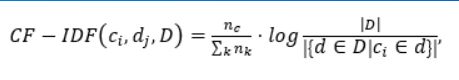


such that : 

    * |D| is the number of documents in the corpus
    * n_c is the number of occurences of concept c in document d
    * n_k is the total number of concepts in this document 

In [8]:
NUM_DOCS = data.shape[0]

# construct a word to concept mapping
word_concept = {}
for index, word in enumerate(word_vecs.keys()):
    word_concept[word] = concepts[index]
print(word_concept)

{'فساد': 26, 'بتحكوا': 61, 'انو': 86, 'اساس': 112, 'حلو': 74, 'رائع': 18, 'لسان': 94, 'قذر': 7, 'قمام': 2, 'داشر': 7, 'منزل': 38, 'انكب': 111, 'متزوج': 21, 'اجيد': 34, 'مخدر': 128, 'مشبوه': 55, 'تسليك': 85, 'ولد': 21, 'اهرب': 5, 'متوتر': 9, 'احش': 111, 'تحسن': 0, 'ابشر': 61, 'اله': 37, 'قريب': 49, 'غباء': 76, 'عود': 94, 'بيت': 71, 'راعي': 29, 'شاب': 21, 'قطع': 57, 'معيتق': 2, 'سلام': 1, 'راحم': 105, 'رحم': 65, 'قران': 88, 'مؤمن': 70, 'دافع': 87, 'شفع': 108, 'نبي': 68, 'ملائكه': 122, 'اتحزن': 2, 'دعاء': 88, 'يعدك': 4, 'ارحم': 51, 'استغفر': 42, 'سلم': 24, 'صلا': 2, 'حسن': 121, 'وعد': 94, 'هوي': 105, 'خشي': 24, 'اتعلق': 97, 'لان': 110, 'مقرف': 18, 'تعليق': 43, 'اتفه': 126, 'عالمي': 129, 'برنامج': 43, 'رفع': 58, 'راتب': 16, 'حضيض': 2, 'حواء': 119, 'خرفنه': 85, 'اجتماع': 32, 'واضح': 112, 'خام': 128, 'والا': 53, 'معو': 86, 'كريم': 121, 'رسول': 65, 'بايخ': 74, 'شارك': 89, 'احتمال': 8, 'احذف': 14, 'جلس': 89, 'اني': 15, 'اكفر': 34, 'حشيش': 128, 'احس': 31, 'بال': 94, 'شيء': 103, 'عمل': 57, 'استم

In [9]:
# construct a concept to document count mapping
concept_docs = defaultdict(int)
for doc in data["tweet"]:
    doc_concepts = set()
    for word in doc.split(" "):
        try:
            doc_concepts.add(word_concept[word])
        except Exception:
            pass
    for concept in doc_concepts:
        concept_docs[concept] += 1
print(concept_docs)

defaultdict(<class 'int'>, {74: 64, 112: 49, 86: 83, 26: 48, 61: 150, 18: 139, 2: 420, 94: 270, 7: 114, 128: 79, 34: 45, 5: 4, 38: 110, 9: 37, 111: 44, 21: 150, 85: 120, 55: 100, 0: 43, 49: 38, 37: 385, 71: 61, 76: 152, 29: 90, 57: 135, 1: 56, 65: 25, 121: 161, 68: 30, 70: 79, 4: 68, 105: 102, 42: 4, 108: 83, 51: 76, 87: 132, 88: 60, 24: 109, 122: 116, 97: 17, 43: 112, 110: 62, 129: 104, 126: 22, 16: 25, 58: 34, 32: 12, 119: 74, 53: 85, 8: 61, 89: 82, 14: 16, 15: 2, 31: 32, 82: 49, 103: 61, 64: 77, 100: 91, 41: 54, 98: 51, 78: 8, 35: 59, 20: 32, 81: 15, 96: 35, 90: 3, 69: 14, 30: 1, 95: 1, 25: 64, 10: 77, 28: 70, 127: 6, 12: 139, 11: 75, 104: 94, 46: 27, 39: 130, 54: 88, 118: 23, 59: 28, 79: 57, 48: 29, 106: 10, 84: 27, 123: 55, 22: 34, 115: 20, 19: 43, 40: 54, 13: 1, 125: 102, 47: 31, 23: 21, 60: 32, 33: 15, 99: 5, 80: 17, 113: 6, 101: 27, 109: 7, 91: 2, 67: 13, 102: 42, 124: 22, 27: 3, 63: 9, 75: 2, 45: 2, 120: 1, 6: 3, 92: 2, 116: 2, 44: 2, 62: 4, 52: 12, 83: 4, 3: 2, 56: 2, 77: 7, 

In [10]:
def cf_idf(document: str):
    """ Returns the CD-IDF representataion of a document """
    res = [0 for _ in range(NUM_CONCEPTS)]
    concepts_counts = defaultdict(int)
    for word in document.split(" "):
        try:
            concepts_counts[word_concept[word]] += 1
        except:
            pass
    n_k = sum(concepts_counts.values()) # number of concepts present in the document (duplicates are considered!)
    for concept in range(NUM_CONCEPTS):
        if concepts_counts[concept] != 0:
            res[concept] = (concepts_counts[concept] / n_k) * log(NUM_DOCS / (1 + concept_docs[concept]))
    return res

In [11]:
X = [cf_idf(tweet) for tweet in data["tweet"]]
y = data["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = SEED, stratify = y)

### Performance evaluation
#### Naive bayes

In [12]:
model = GaussianNB()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="Positive")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

Accuracy: 62.18%
Precesion : 90.57%
Recall : 26.97%
F1 score : 41.56%


#### Logistic regression

In [12]:
model = LogisticRegression(random_state = SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="Positive")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

Accuracy: 80.39%
Precesion : 81.40%
Recall : 78.65%
F1 score : 80.00%


#### SVM

In [13]:
model = SVC(random_state = SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="Positive")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

Accuracy: 75.35%
Precesion : 75.86%
Recall : 74.16%
F1 score : 75.00%


#### Random Forest

In [14]:
rf = RandomForestClassifier(random_state = SEED)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="Positive")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

Accuracy: 73.67%
Precesion : 74.14%
Recall : 72.47%
F1 score : 73.30%
